<a href="https://colab.research.google.com/github/gurpreetgosal/Algorithms_search_sort/blob/master/Instacart_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_trips = pd.read_csv("/content/drive/My Drive/instacart_data/train_trips.csv",\
                         parse_dates=['shopping_started_at','shopping_ended_at'])
test_trips  = pd.read_csv("/content/drive/My Drive/instacart_data/test_trips.csv",
                         parse_dates=['shopping_started_at'])
order_items = pd.read_csv("/content/drive/My Drive/instacart_data/order_items.csv")

## 1. Data Exploration

Let's first have a glance at the data in all tables

In [204]:
order_items.head(5)

,trip_id,item_id,department_name,quantity
0,3119513,368671,Produce,10.0
1,3120462,368671,Produce,10.0
2,3120473,368671,Produce,10.0
3,3121910,368671,Produce,6.0
4,3122332,368671,Produce,10.0


In [205]:
train_trips.head(5)

,trip_id,shopper_id,fulfillment_model,store_id,shopping_started_at,shopping_ended_at
0,3119519,48539,model_1,6,2015-09-01 07:03:56,2015-09-01 07:30:56
1,3119513,3775,model_1,1,2015-09-01 07:04:33,2015-09-01 07:40:33
2,3119516,4362,model_1,1,2015-09-01 07:23:21,2015-09-01 07:41:21
3,3119792,47659,model_1,1,2015-09-01 07:29:52,2015-09-01 08:55:52
4,3119922,11475,model_1,1,2015-09-01 07:32:21,2015-09-01 09:01:21


In [206]:
test_trips.head(5)

,trip_id,shopper_id,fulfillment_model,store_id,shopping_started_at
0,4310899,60930,model_2,123,2015-11-16 07:00:12
1,4310904,59815,model_2,123,2015-11-16 07:00:12
2,4310907,60878,model_2,123,2015-11-16 07:00:13
3,4310911,60879,model_2,123,2015-11-16 07:00:13
4,4310328,66726,model_1,1,2015-11-16 07:01:08


In [207]:
print("nulls in train_trips \n",train_trips.isnull().any(),"\n")
print("nulls in test_trips \n",test_trips.isnull().any(),"\n")
print("nulls in order_items \n",order_items.isnull().any(),"\n")

nulls in train_trips 
 trip_id                False
shopper_id             False
fulfillment_model      False
store_id               False
shopping_started_at    False
shopping_ended_at      False
dtype: bool 

nulls in test_trips 
 trip_id                False
shopper_id             False
fulfillment_model      False
store_id               False
shopping_started_at    False
dtype: bool 

nulls in order_items 
 trip_id            False
item_id            False
department_name    False
quantity           False
dtype: bool 



Thus, there are no missing values in the datasets.

Next, lets explore what's the average number of items that are purchased per trip . To do this we focus on 'order_items'  data


In [208]:
grouped_items_by_trip = order_items.groupby(['trip_id']).item_id.nunique()
print("number of unique items purchased per trip = ", \
                grouped_items_by_trip.sum()/len(grouped_items_by_trip))

number of unique items purchased per trip =  15.851806386450159


There were unique 15.85 items purchased per trip.

Now, let's look at average quantity of items purchased per trip and number of different departments visited per trip.

In [209]:
grouped_quantities_by_trip = order_items.groupby(['trip_id']).agg({'quantity':np.sum})
print("average quantity of all items bought per trip = ", \
                   grouped_quantities_by_trip.sum()/len(grouped_quantities_by_trip))

grouped_departments_by_trip = order_items.groupby(['trip_id']).department_name.nunique()
print("average number of departments visited per trip = ", \
                    grouped_departments_by_trip.sum()/len(grouped_departments_by_trip))

average quantity of all items bought per trip =  quantity    25.54083
dtype: float64
average number of departments visited per trip =  6.664517131536011


There avg. of the quantity of all items bought in a trip is 25.54
and the average number of departments visited per visit are 6.67

Intuitively we can say that these quantites ie. average quantity per trip, average items per trip and average number of departments visited per trip should have a lot of bearing on the response variable which is shopping time. 
This we will explore further but first let's join the train_trip and order_items datasets.


In [210]:
# First get shopping time for start and end times
# get differece in seconds
train_trips['trip_shop_time'] = (train_trips['shopping_ended_at'] - \
                                 train_trips['shopping_started_at']).dt.total_seconds()

# join train_trips with order_items
merged_train_order = train_trips.merge(order_items, how='left',on = 'trip_id')
merged_train_order.head(5)

,trip_id,shopper_id,fulfillment_model,store_id,shopping_started_at,shopping_ended_at,trip_shop_time,item_id,department_name,quantity
0,3119519,48539,model_1,6,2015-09-01 07:03:56,2015-09-01 07:30:56,1620.0,619098,Meat & Seafood,1.0
1,3119519,48539,model_1,6,2015-09-01 07:03:56,2015-09-01 07:30:56,1620.0,313592,Produce,1.0
2,3119519,48539,model_1,6,2015-09-01 07:03:56,2015-09-01 07:30:56,1620.0,979903,Bakery,1.0
3,3119519,48539,model_1,6,2015-09-01 07:03:56,2015-09-01 07:30:56,1620.0,1331310,Breakfast,1.0
4,3119519,48539,model_1,6,2015-09-01 07:03:56,2015-09-01 07:30:56,1620.0,1329835,Snacks,2.0


Let's look closely at the ID columns ie trip_id, shopper_id and store_id.
trip_id is a unique value that identifies a trip in the training set (train_trips)
shopper_id represents a unique shopper whereas store_id identifies a grocery store.


In [211]:
print('counts of unique IDs')
merged_train_order[['trip_id','shopper_id','store_id']].nunique()

counts of unique IDs


trip_id       117063
shopper_id      1506
store_id          14
dtype: int64

Similarly, for the test_trips, trip_id uniquely identifies a row.
Therefore, trip_id shouldn't be a feature/predictor for shopping time. As we will see in the next sections shopper_id and store_id will be used as two of the predictors. 

We can better understand the correlation of shopper_id and store_id with that of shopping time through visualizations.

Text(0,0.5,'shopping time in seconds')

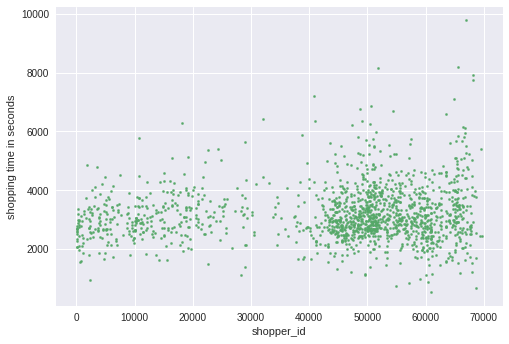

In [212]:
# plot shopping time versus shopper_id
groupby_shopper_id = merged_train_order.groupby(['shopper_id']).agg({'trip_shop_time':np.mean}).reset_index()
plt.scatter(groupby_shopper_id['shopper_id'],\
        groupby_shopper_id['trip_shop_time'], \
            5,label='shopping time wrt. shopper_id',color='C1')
plt.xlabel('shopper_id')
plt.ylabel('shopping time in seconds')



Text(0,0.5,'shopping time in seconds')

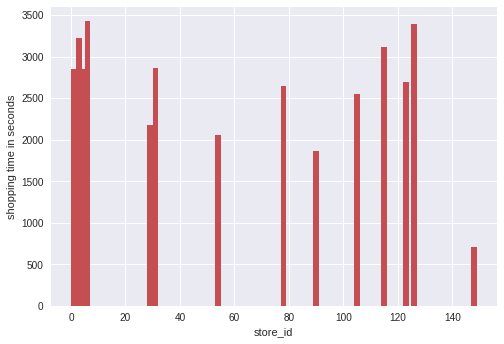

In [213]:
# plot shopping time versus store_id
groupby_store_id = merged_train_order.groupby(['store_id']).agg({'trip_shop_time':np.mean}).reset_index()
plt.bar(groupby_store_id['store_id'],\
        groupby_store_id['trip_shop_time'], \
            2,label='shopping time wrt. store_id',color='C2',
           align='center')
plt.xlabel('store_id')
plt.ylabel('shopping time in seconds')

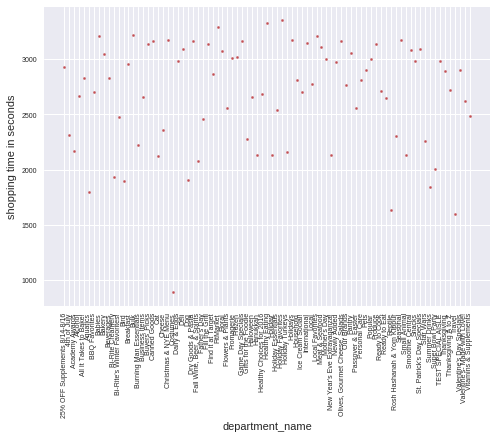

In [214]:
# shopping time versus department
groupby_department = merged_train_order.groupby(['department_name']).agg({'trip_shop_time':np.mean}).reset_index()
plt.scatter(groupby_department['department_name'],\
        groupby_department['trip_shop_time'], \
            5,label='shopping time wrt. department_name',color='C2')
plt.xlabel('department_name')
plt.xticks(rotation=90)
plt.ylabel('shopping time in seconds')
ax = plt.gca()
ax.tick_params(axis='both', which='major',labelsize=7)

Distribution of shopping time. 

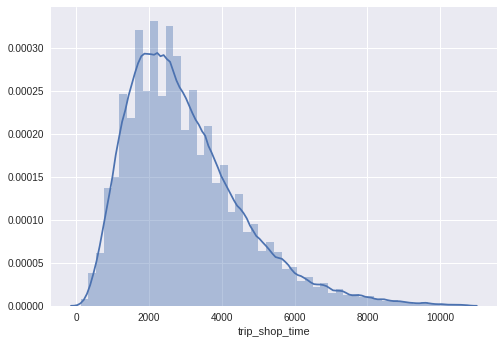

In [215]:
# shopping time distribution
sns.distplot(merged_train_order['trip_shop_time'])

## 2. Feature Engineering

In [216]:
print("number of departments=",len(finalTrainData['department_name'].unique()))

number of departments= 83


As we can see in the above plots, there is a significant variation in shopping time among different departments, so it will be good idea to represent this in our feature set.  To do this a new set of columns are created that represent quantity of items for each department. 

There are 83 unique departments in all the stores which will introduce 83 new columns representing quantity for each of the department for a specific trip's shopper_id, store_id combination.

First prepare data that give total count of departments visited per trip for a 
(shopper_id, store_id) at a specific time
To do this, 'trip_id','store_id','department_name','item_id','fulfillment_model',
'shopping_started_at' are considered to be the primary keys and 'quantity', 'item_id', 'trip_shop_time',
 are aggregated and 'shopped_id' would remain the same for these primary keys

In [217]:
combined_count_data= merged_train_order.groupby(['trip_id','store_id','department_name',\
              'fulfillment_model','shopping_started_at']).agg({'quantity':np.sum,\
               'trip_shop_time':np.mean,'shopper_id':np.mean, 'item_id':'nunique'}).reset_index()
# Next we can drop 'fulfilment_model'
combined_count_data = combined_count_data.groupby(['trip_id','store_id','shopper_id','shopping_started_at']).\
                        agg({'item_id':'nunique', 'trip_shop_time':np.mean, \
                             'quantity':np.mean, 'department_name':'nunique'}).reset_index()
combined_count_data = combined_count_data.rename(columns = {'item_id':'total_unique_items','department_name':'total_depts_visited',
                                 'quantity':'total_quantity'})
combined_count_data.head(5)



,trip_id,store_id,shopper_id,shopping_started_at,total_unique_items,trip_shop_time,total_quantity,total_depts_visited
0,3119513,1,3775,2015-09-01 07:04:33,5,2160.0,22.875000,8
1,3119516,1,4362,2015-09-01 07:23:21,1,1080.0,1.800000,5
2,3119518,1,10720,2015-09-01 07:37:53,4,2460.0,3.500000,6
3,3119519,6,48539,2015-09-01 07:03:56,5,1620.0,3.545455,11
4,3119520,115,43442,2015-09-01 07:39:11,5,3600.0,2.571429,14


Correlation matrix will give a picture of how shopping time varies with all other predictors.

As we can see below 'total_unique_items', 'total_depts_visited', total_quantity' are the top three correlated predictors for shopping time

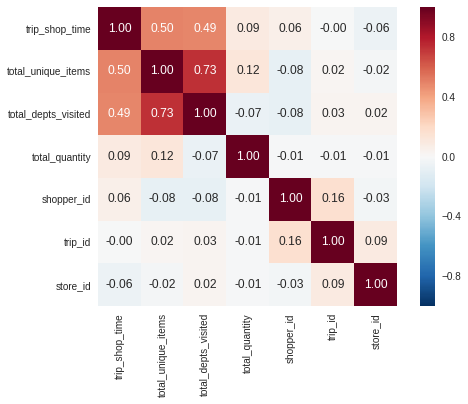

In [218]:
correlation = combined_count_data.corr(method='pearson')
columns = correlation.nlargest(10, 'trip_shop_time').index

correlation_map = np.corrcoef(combined_count_data[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, \
                      fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

Next, prepare data to get counts of each department's unique item count and quantity. And finally concatenate this dataframe with 'combined_count_data' 

In [219]:
dept_count_data = merged_train_order.groupby(['trip_id','store_id','department_name',\
              'fulfillment_model','shopping_started_at']).agg({'quantity':np.sum,\
               'trip_shop_time':np.mean,'shopper_id':np.mean, 'item_id':'nunique'}).reset_index()

dept_count_data = dept_count_data.groupby(['trip_id','store_id','department_name']).agg \
                        ({'quantity':np.mean, 'trip_shop_time':np.mean, 'shopper_id':np.mean, \
                         'item_id':'nunique'}).reset_index()
dept_count_data = dept_count_data.rename(columns= {'quantity':'dept_quantity', \
                                                   'item_id':'dept_item_count'})

dept_count_data.head(5)



,trip_id,store_id,department_name,dept_quantity,trip_shop_time,shopper_id,dept_item_count
0,3119513,1,Beverages,8.0,2160.0,3775,1
1,3119513,1,Dairy & Eggs,28.0,2160.0,3775,1
2,3119513,1,Deli,1.0,2160.0,3775,1
3,3119513,1,International,1.0,2160.0,3775,1
4,3119513,1,Pantry,1.0,2160.0,3775,1


AS discussed above, we will add new columns representing each department's unique items and quantity. 

In [220]:
pivoted_dept_table = pd.pivot_table(dept_count_data, columns=['department_name'], \
              values=['dept_item_count', 'dept_quantity'], fill_value=0,index='trip_id')
# pivoted_dept_table.head(5)
pivoted_dept_table.columns = [' '.join(col).strip() for col in pivoted_dept_table.columns.values]
pivoted_dept_table = pivoted_dept_table.reset_index()
pivoted_dept_table.head(5)



,trip_id,dept_item_count 25% OFF Supplements 8/14-8/16,dept_item_count 4th of July,dept_item_count Academy Awards,dept_item_count Alcohol,dept_item_count All It Takes to Bake!,dept_item_count Aquatics,dept_item_count BBQ Favorites,dept_item_count Babies,dept_item_count Bakery,...,dept_quantity Star Wars,dept_quantity Summer Drinks,dept_quantity Super Bowl Party,dept_quantity TEST SPECIAL AISLE,dept_quantity Thanksgiving,dept_quantity Thanksgiving A to Z,dept_quantity Travel,dept_quantity Valentine's Day Specials,dept_quantity Valentine's- Made with Love!,dept_quantity Vitamins & Supplements
0,3119513,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0
1,3119516,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0
2,3119518,0,0,0,0,0,0,0,0,1,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0
3,3119519,0,0,0,0,0,0,0,0,1,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0
4,3119520,0,0,0,1,0,0,0,1,1,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0


Now that we have department count of items and quantity as well as a dataframe with total count of items and quantity, concatenate these dataframes

In [221]:
combined_count_data = combined_count_data.rename(columns={'trip_id':'trip_id_1'})
combined_train_data = pd.concat([combined_count_data,pivoted_dept_table],axis=1)
combined_train_data = combined_train_data.drop(['trip_id_1'],axis=1).drop_duplicates()
combined_train_data.head(5)

,store_id,shopper_id,shopping_started_at,total_unique_items,trip_shop_time,total_quantity,total_depts_visited,trip_id,dept_item_count 25% OFF Supplements 8/14-8/16,dept_item_count 4th of July,...,dept_quantity Star Wars,dept_quantity Summer Drinks,dept_quantity Super Bowl Party,dept_quantity TEST SPECIAL AISLE,dept_quantity Thanksgiving,dept_quantity Thanksgiving A to Z,dept_quantity Travel,dept_quantity Valentine's Day Specials,dept_quantity Valentine's- Made with Love!,dept_quantity Vitamins & Supplements
0,1,3775,2015-09-01 07:04:33,5,2160.0,22.875000,8,3119513,0,0,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0
1,1,4362,2015-09-01 07:23:21,1,1080.0,1.800000,5,3119516,0,0,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0
2,1,10720,2015-09-01 07:37:53,4,2460.0,3.500000,6,3119518,0,0,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0
3,6,48539,2015-09-01 07:03:56,5,1620.0,3.545455,11,3119519,0,0,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0
4,115,43442,2015-09-01 07:39:11,5,3600.0,2.571429,14,3119520,0,0,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0


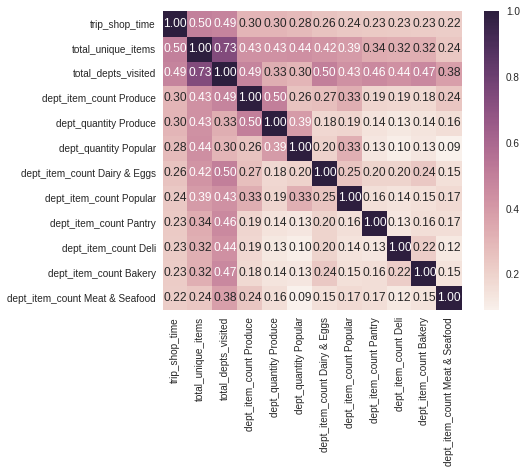

In [222]:
# plotting top 12 highly correlated predictors with the response
correlation = combined_train_data.corr(method='pearson')
columns = correlation.nlargest(12, 'trip_shop_time').index

correlation_map = np.corrcoef(combined_train_data[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, \
                      fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

Next, we can better utilize the 'shopping_started_at' time stamp by breaking it down to hour, day, week but for the first iteration it will be ignored

In [223]:
# for now time the shopping started at is dropped but in future it can be used to get
combined_train_data_dropped_time = combined_train_data.drop(['shopping_started_at','trip_id'],axis=1)
combined_train_data_dropped_time = combined_train_data_dropped_time.drop_duplicates()
combined_train_data_dropped_time.head(5)

,store_id,shopper_id,total_unique_items,trip_shop_time,total_quantity,total_depts_visited,dept_item_count 25% OFF Supplements 8/14-8/16,dept_item_count 4th of July,dept_item_count Academy Awards,dept_item_count Alcohol,...,dept_quantity Star Wars,dept_quantity Summer Drinks,dept_quantity Super Bowl Party,dept_quantity TEST SPECIAL AISLE,dept_quantity Thanksgiving,dept_quantity Thanksgiving A to Z,dept_quantity Travel,dept_quantity Valentine's Day Specials,dept_quantity Valentine's- Made with Love!,dept_quantity Vitamins & Supplements
0,1,3775,5,2160.0,22.875000,8,0,0,0,0,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0
1,1,4362,1,1080.0,1.800000,5,0,0,0,0,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0
2,1,10720,4,2460.0,3.500000,6,0,0,0,0,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0
3,6,48539,5,1620.0,3.545455,11,0,0,0,0,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0
4,115,43442,5,3600.0,2.571429,14,0,0,0,1,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0


## 3. Model Building

Start with simple model like Linear Regression and then move to ensemble models like gradient boosting 

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, explained_variance_score


In [0]:
X = combined_train_data_dropped_time.drop(['trip_shop_time'],axis=1)
Y = combined_train_data_dropped_time[['trip_shop_time']]
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.20, random_state=100)

In [165]:
lr_ = LinearRegression().fit(X_train,Y_train)
print('The r2 score on validation data for least squares regression is: ', lr_.score(X_val,Y_val))



The r2 score on validation data for least squares regression is:  0.3170974387433778


In [0]:
# remove outliers


Try regression trees.

In [157]:
decision_tree_ = RandomForestRegressor(n_estimators=1200,min_samples_split=4,max_depth=5).\
                                        fit(X_train,Y_train)
print('The r2 score on validation data for random forrest regressor is: ', decision_tree_.score(X_val,Y_val))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


The r2 score on validation data for decision tree is:  0.3576449470006756




> Indented block



In [163]:
grad_boosting = GradientBoostingRegressor(n_estimators=2500,max_depth=5,\
                              min_samples_split=4,loss='ls').fit(X_train,Y_train)
print("The r2 score on validation data for gradient boosting is:", grad_boosting.score(X_val,Y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The r2 score on validation data for gradient boosting is: 0.43801905530411556


## 4. Predictions on test set

Based on the accuracy metric, GradientBoostingRegressor is the best performing model on the validation set. Predictions are made for the test set using this.

In [0]:
def feature_engineering_test(trip_test_data, order_items):
    

    # join train_trips with order_items
    merged_with_order = trip_test_data.merge(order_items, how='left',on = 'trip_id')
    
    combined_count_data= merged_with_order.groupby(['trip_id','store_id','department_name',\
              'fulfillment_model','shopping_started_at']).agg({'quantity':np.sum,\
              'shopper_id':np.mean, 'item_id':'nunique'}).reset_index()
    # Next we can drop 'fulfilment_model'
    combined_count_data = combined_count_data.groupby(['trip_id','store_id','shopper_id','shopping_started_at']).agg({'item_id':'nunique', \
        'quantity':np.mean, 'department_name':'nunique'}).reset_index()
    combined_count_data = combined_count_data.rename(columns = {'item_id':'total_unique_items','department_name':'total_depts_visited','quantity':'total_quantity'})
    
    
    dept_count_data = merged_with_order.groupby(['trip_id','store_id','department_name',\
              'fulfillment_model','shopping_started_at']).agg({'quantity':np.sum,\
               'shopper_id':np.mean, 'item_id':'nunique'}).reset_index()

    dept_count_data = dept_count_data.groupby(['trip_id','store_id','department_name']).agg \
                            ({'quantity':np.mean,  'shopper_id':np.mean, \
                             'item_id':'nunique'}).reset_index()
    dept_count_data = dept_count_data.rename(columns= {'quantity':'dept_quantity', \
                                                       'item_id':'dept_item_count'})
                                                       
    pivoted_dept_table = pd.pivot_table(dept_count_data, columns=['department_name'], \
              values=['dept_item_count', 'dept_quantity'], fill_value=0,index='trip_id')
    pivoted_dept_table.columns = [' '.join(col).strip() for col in pivoted_dept_table.columns.values]
    pivoted_dept_table = pivoted_dept_table.reset_index()
    
    combined_count_data = combined_count_data.rename(columns={'trip_id':'trip_id_1'})
    combined_test_data = pd.concat([combined_count_data,pivoted_dept_table],axis=1)
    combined_test_data = combined_test_data.drop(['trip_id_1'],axis=1).drop_duplicates()
    
    combined_test_data_dropped_time = combined_test_data.drop(\
                                              ['shopping_started_at'],axis=1)
    combined_test_data_dropped_time = combined_test_data_dropped_time.drop_duplicates()
    
    X_test = combined_test_data_dropped_time
    return X_test

In [0]:
X_test = feature_engineering_test(test_trips, order_items)


test_cols = [c for c in X_test.columns if c in list(X_train.columns)]  
test_cols.append('trip_id')
X_test = X_test[test_cols]

cols_not_in_test = [c for c in X_train.columns if c not in list(X_test.columns)]
for col_ in cols_not_in_test:
  X_test[col_] = 0.0

X_test = X_test.set_index('trip_id')
  
Y_test = grad_boosting.predict(X_test)
#output = pd.DataFrame(np.vstack((Y_test, X_test.reset_index()['trip_id'])).T)
#output[]
X_test = X_test.reset_index()
X_test.as_matrix(columns=['trip_id'])
output = pd.DataFrame(np.vstack((np.asarray(X_test.as_matrix(columns=['trip_id'])).reshape(-1),\
                          Y_test)).T, columns=['trip_id', 'shopping_time']).round(decimals=2)
output.trip_id = output.trip_id.astype(int)
output.to_csv("/content/drive/My Drive/instacart_data/output.csv",index=False)
